In [52]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats as sps
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generate data

* Относительно предыдущей тетрадки добавим softmax на параметры alpha. И Variational inference добавим.

In [25]:
def gen_first(alpha, w, X, noise_sigma=0):
    """alpha, w, size - tuples with 2 elements
    x = alpha[0] * sin(w[0] * x) + alpha[1] * cos(w[1] * x) + N(0, noise_sigma^2), 
    X - list with x_train, x_val, x_test..."""
    Y = []
    assert alpha[0] + alpha[1] == 1
    for x in X:
        x = np.array(x)
        y = alpha[0] * np.sin(w[0] * x) + alpha[1] * np.cos(w[1] * x)
        y += np.random.randn(x.shape[0]) * noise_sigma
        Y.append(y)
    return Y

In [133]:
x_max = 2
X = sps.uniform(loc=0, scale=x_max).rvs(size=1000)
X_train, X_test = train_test_split(X, test_size=0.2)
X_train, X_val = train_test_split(X_train, test_size=0.3)

In [134]:
alpha = [0.2, 0.8]
w = [2, 3]
y_train, y_val, y_test = gen_first(alpha, w, [X_train, X_val, X_test], noise_sigma=0.01)

In [135]:
print(f'alpha true = {alpha}')
print(f'w true = {w}')

alpha true = [0.2, 0.8]
w true = [2, 3]


### Model

In [136]:
def true_func(alpha, w, x):
    return alpha[0] * np.sin(w[0] * x) + alpha[1] * np.cos(w[1] * x)

In [137]:
class ModelFirst(torch.nn.Module):
    def __init__(self):
        super(ModelFirst, self).__init__()
        self.alpha = torch.tensor([1, 1], dtype=torch.float64, requires_grad=True)
        self.w = torch.tensor([1, 1], dtype=torch.float64, requires_grad=True)
        
    def forward(self, x):
        mixed_op = torch.nn.Softmax(dim=0)(self.alpha)
        return mixed_op[0] * torch.sin(self.w[0] * x) + mixed_op[1] * torch.cos(self.w[1] * x)

In [138]:
def compute_loss(model, x, y):
    """x, y - numpy arrays"""
    x = torch.DoubleTensor(x)
    y = torch.DoubleTensor(y)
    y_pred = model(x)
    return F.mse_loss(y_pred, y)# + 0.001 * (model.alpha ** 2).sum() + 0.001 * (model.w ** 2).sum()

## Darts

In [139]:
def find_opt(model, xi=0.1, num_epochs=100):
    train_loss, val_loss, test_loss, params = [], [], [], []
    
    opt_w = torch.optim.SGD([model.w], lr=xi)
    opt_alpha = torch.optim.SGD([model.alpha], lr=0.1)

    for epoch in range(num_epochs):
        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        loss = compute_loss(model, X_train, y_train) # first level
        loss.backward()
        w_grad = model.w.grad.clone().detach()
        opt_w.step()
        opt_w.zero_grad()
        opt_alpha.zero_grad()
        train_loss.append(loss.data.numpy())
                
        model.w.requires_grad_(False)
        model.w -= w_grad * xi # virtual step
                
        loss = compute_loss(model, X_val, y_val) # second level
        loss.backward()
        opt_alpha.step()
        opt_alpha.zero_grad()
        opt_w.zero_grad()
        val_loss.append(loss.data.numpy())
        
        model.w += w_grad * xi
        model.w = model.w.requires_grad_(True)
        params.append((model.alpha.clone().detach().numpy(), model.w.clone().detach().numpy()))
                
        loss = compute_loss(model, X_test, y_test)
        test_loss.append(loss.data.numpy())
    return train_loss, val_loss, test_loss, np.array(params)

In [140]:
best_loss = 100
for xi in tqdm(np.linspace(0.01, 0.5, num=10)):
    model = ModelFirst()
    train_loss, val_loss, test_loss, params = find_opt(model, xi=xi, num_epochs=1001)
    if train_loss[-1] < best_loss:
        best_loss = train_loss[-1]
        best_xi = xi
        model_best = model
print(f'best_loss = {best_loss}')


best_loss = 0.0021669854113520698


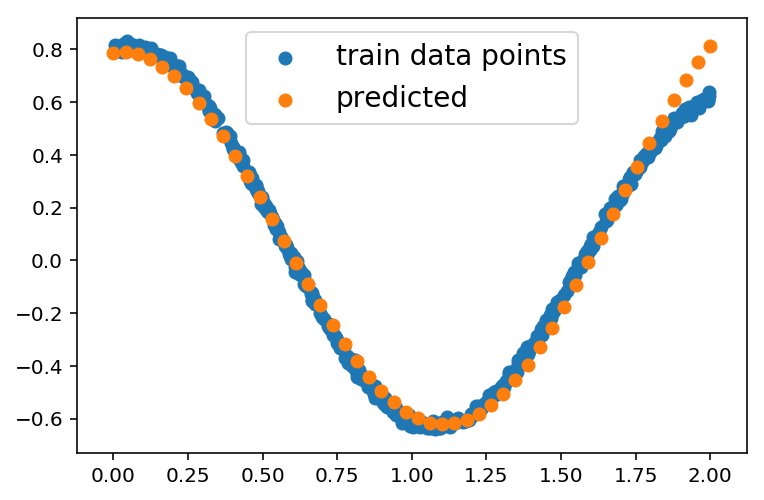

In [141]:
plt.scatter(X_train, y_train, label='train data points')
plt.scatter(np.linspace(0, x_max), [true_func(torch.nn.Softmax(dim=0)(model_best.alpha).detach().numpy(), 
                                          model_best.w.detach().numpy(), x)
                                 for x in np.linspace(0, x_max)], label='predicted')
plt.legend(prop={'size': 14})
plt.show()

Выводы:
* Градиентный спуск не всесилен и возникают большие проблемы с застряванием в локальных минимумах, а не в глобальным при использовании функций активации с большим кол-вом экстремумов (например, sin, cos при условии что x принимает значения на большом промежутке > pi)

In [142]:
model_best.w

tensor([0.8063, 2.7916], dtype=torch.float64, requires_grad=True)

In [143]:
model_best.alpha, torch.nn.Softmax(dim=0)(model_best.alpha).detach().numpy()

(tensor([0.3438, 1.6562], dtype=torch.float64, requires_grad=True),
 array([0.21207942, 0.78792058]))

In [144]:
best_loss, best_xi

(array(0.00216699), 0.5)